In [ ]:
!pip install scikit-multilearn
!pip install arff

     |████████████████████████████████| 92kB 8.2MB/s 
  Created wheel for arff: filename=arff-0.9-cp37-none-any.whl size=4970 sha256=254393c683369441048c2e11afe066297f9ee4dfcaaf19731b4d65a44d211bc2
  Stored in directory: /root/.cache/pip/wheels/04/d0/70/2c73afedd3ac25c6085b528742c69b9587cbdfa67e5194583b
Successfully built arff


# 0. Imports and Utils

In [ ]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from skmultilearn.model_selection import IterativeStratification

from sklearn.model_selection import train_test_split

# 1. Data

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/PFM/data/data.csv", encoding='utf-8-sig').drop('Unnamed: 0', axis=1)

In [ ]:
data.head()

,title,description,taxonomy,subtaxonomy
0,London Dungeon LATES with Cocktail,"Lates mashes up theatre, special effects and i...",273,275
1,Drumchapel & West Winterfest Fireworks,Don't miss Drumchapel's annual fireworks extra...,273,275
2,MEGALAND 2019,MEGALAND 2019 in the SimÃ³n Bolivar Park. Live...,173,201
3,Extravaganza,It's Extravaganza time at Ferrymead Heritage P...,273,275
4,A Nightmare on Duddell's Street,"Disco Bao is back, this time with a freaky twi...",173,267


# 2. Multi-class Classification (Taxonomy Only)

In [ ]:
# detach text and target
X = data.drop(['taxonomy', 'subtaxonomy'], axis=1)
y = data['taxonomy'].values

In [ ]:
X.shape, y.shape

((59879, 2), (59879,))

In [ ]:
# test set: 15%
tmp_X_train, X_test, tmp_y_train, y_test = train_test_split(
    X, y,
    test_size=0.15,
    stratify=y
)

**QUALITY CHECK**

In [ ]:
tmp_X_train.head()

,title,description
37395,The Frontm3n,NaN
11105,Blossom Festival 2019,NaN
48809,Dillbilly / Sorceress of the Sky / Wayfairy,Dillbilly\nSorceress of the Sky\nWayfairy\nThu...
32674,Omerta Tradycyjny Pub Quiz,Zapraszamy na Pub Quiz i craftowe piwka do Ome...
32459,Roof Fest 2019,"Since 2012, the St. Petersburg Roof Fest has b..."


In [ ]:
tmp_y_train[:4]

array([173, 173, 173, 273])

In [ ]:
data.loc[32674]

title                                 Omerta Tradycyjny Pub Quiz
description    Zapraszamy na Pub Quiz i craftowe piwka do Ome...
taxonomy                                                     273
subtaxonomy                                                  275
Name: 32674, dtype: object

In [ ]:
print(np.unique(tmp_y_train))
np.unique(tmp_y_train).shape

[  2   9  59  70 173 268 273 280]


(8,)

{2, 9, 59, 70, 173, 268, 273, 280}

In [ ]:
# class dist
from collections import Counter
Counter(tmp_y_train), Counter(y_test)

(Counter({2: 5085,
          9: 115,
          59: 4496,
          70: 2788,
          173: 15844,
          268: 8053,
          273: 10100,
          280: 4416}),
 Counter({2: 898,
          9: 20,
          59: 794,
          70: 492,
          173: 2796,
          268: 1421,
          273: 1782,
          280: 779}))

_________

In [ ]:
# train and validation
# val set: 15% of full dataset
val_size = float(data.shape[0]*0.15 / tmp_X_train.shape[0])
X_train, X_val, y_train, y_val = train_test_split(
    tmp_X_train, tmp_y_train,
    test_size=val_size,
    stratify=tmp_y_train
)

**QUALITY CHECK**

In [ ]:
X_train.head()

,title,description
45768,NATURISTS IN SKIING,Fred and his team have just opened a unique va...
47555,French for Travelers Workshop,"Be a traveler, not a tourist!Would you like to..."
10824,Jeromo Segura Concert - Jose Merce,- UNEMPLOYED *: present an unemployed card at ...
47643,Daisy Johnson: Everything Under,"Last year, British author Daisy Johnson became..."
59342,White Night 2019,"This year, Melbourne's all-night arts extravag..."


In [ ]:
y_train

array([268, 273, 268, ..., 173, 273, 173])

In [ ]:
data.loc[47555]

title                              French for Travelers Workshop
description    Be a traveler, not a tourist!Would you like to...
taxonomy                                                     273
subtaxonomy                                                  196
Name: 47555, dtype: object

In [ ]:
Counter(y_train), Counter(y_val)

(Counter({2: 4188,
          9: 95,
          59: 3702,
          70: 2296,
          173: 13048,
          268: 6632,
          273: 8317,
          280: 3637}),
 Counter({2: 897,
          9: 20,
          59: 794,
          70: 492,
          173: 2796,
          268: 1421,
          273: 1783,
          280: 779}))

_______

In [ ]:
# put sets together
train = X_train.copy()
train['taxonomy'] = y_train
val = X_val.copy()
val['taxonomy'] = y_val
test = X_test.copy()
test['taxonomy'] = y_test

train.shape, val.shape, test.shape

((41915, 3), (8982, 3), (8982, 3))

In [ ]:
train.head()

,title,description,taxonomy
45768,NATURISTS IN SKIING,Fred and his team have just opened a unique va...,268
47555,French for Travelers Workshop,"Be a traveler, not a tourist!Would you like to...",273
10824,Jeromo Segura Concert - Jose Merce,- UNEMPLOYED *: present an unemployed card at ...,268
47643,Daisy Johnson: Everything Under,"Last year, British author Daisy Johnson became...",59
59342,White Night 2019,"This year, Melbourne's all-night arts extravag...",273


In [ ]:
test.head()

,title,description,taxonomy
58477,Concert by Xoel LÃ³pez in Vigo. Festivities of...,Concert by Xoel LÃ³pez in Vigo. Festivities of...,173
24255,Enmusubi jishu festival,Monthly event for good relation and marriage\n...,273
3697,JosÃ© Carreras Farewell Performance in Hong Kong,Almost 50 years into professional operatic sin...,268
25346,Walk on Project 2018: Matthew Sweet + Corizona...,NaN,173
23253,Conducting Masterclass,With Marios Papadopoulos,273


In [ ]:
val.head()

,title,description,taxonomy
44437,The Internet,These neo-soul masters seem to grow in charism...,173
48421,"PaluÃ­, Are You Here?",Tuesday 19:30 Sala 2Helena Caspurro and Pedro ...,173
30485,Volver (ES),NaN,173
46124,Manolo GarcÃ­a,After military since the eighties in Los RÃ¡pi...,173
8639,HotLotz Fine Jewellery Live Auction,"Get your hands on fine jewellery, designer han...",70


In [ ]:
train_index = np.array(train.index)
val_index = np.array(val.index)
test_index = np.array(test.index)
print(f"Indexes in train and val: {np.intersect1d(train_index, val_index)}")
print(f"Indexes in train and test: {np.intersect1d(train_index, test_index)}")
print(f"Indexes in val and test: {np.intersect1d(val_index, test_index)}")

Indexes in train and val: []
Indexes in train and test: []
Indexes in val and test: []


In [ ]:
all_indexes = sorted(np.array(list(train_index) + list(val_index) + list(test_index)))

In [ ]:
(np.array(data.index) == all_indexes).sum() == data.shape[0]

True

In [ ]:
# save as csv
#train.to_csv("/content/drive/MyDrive/Colab Notebooks/PFM/data/train_v0.csv", index=True)
#val.to_csv("/content/drive/MyDrive/Colab Notebooks/PFM/data/val_v0.csv", index=True)
#test.to_csv("/content/drive/MyDrive/Colab Notebooks/PFM/data/test_v0.csv", index=True)

# 3. Subtaxonomy 173: Local Classifier

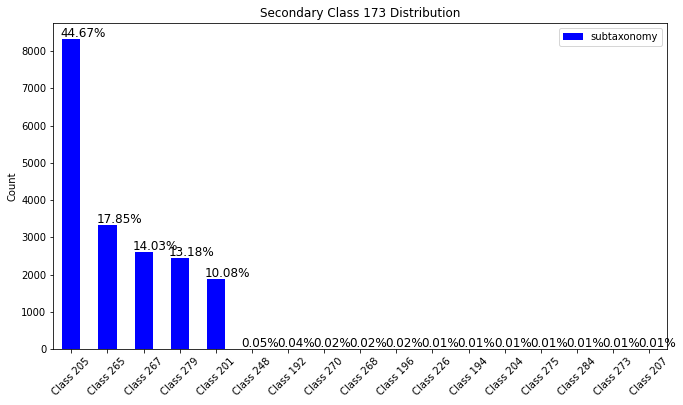

In [ ]:
subset = data.loc[data['taxonomy'] == 173]

In [ ]:
# assume subtaxonomies with a representation smaller than 1% are incorrect labels
to_drop = []
for subtax in (subset['subtaxonomy'].value_counts() / subset.shape[0] < 0.1).items():
  if subtax[1]:
    to_drop.append(subtax[0])

In [ ]:
subset = subset.loc[~subset['subtaxonomy'].isin(to_drop)]

In [ ]:
# detach text and target
X = subset.drop(['taxonomy', 'subtaxonomy'], axis=1)
y = subset['subtaxonomy'].values

In [ ]:
np.unique(y)

array([201, 205, 265, 267, 279])

In [ ]:
# test set: 15%
tmp_X_train, X_test, tmp_y_train, y_test = train_test_split(
    X, y,
    test_size=0.15,
    stratify=y
)

In [ ]:
# class dist
from collections import Counter
Counter(tmp_y_train), Counter(y_test)

(Counter({201: 1597, 205: 7078, 265: 2828, 267: 2224, 279: 2088}),
 Counter({201: 282, 205: 1249, 265: 499, 267: 392, 279: 369}))

In [ ]:
# train and validation
# val set: 15% of full dataset
val_size = float(subset.shape[0]*0.15 / tmp_X_train.shape[0])
X_train, X_val, y_train, y_val = train_test_split(
    tmp_X_train, tmp_y_train,
    test_size=val_size,
    stratify=tmp_y_train
)

In [ ]:
Counter(y_train), Counter(y_val)

(Counter({201: 1315, 205: 5829, 265: 2329, 267: 1831, 279: 1720}),
 Counter({201: 282, 205: 1249, 265: 499, 267: 393, 279: 368}))

In [ ]:
# put sets together
train = X_train.copy()
train['subtaxonomy'] = y_train
val = X_val.copy()
val['subtaxonomy'] = y_val
test = X_test.copy()
test['subtaxonomy'] = y_test

train.shape, val.shape, test.shape

((13024, 3), (2791, 3), (2791, 3))

In [ ]:
train_index = np.array(train.index)
val_index = np.array(val.index)
test_index = np.array(test.index)
print(f"Indexes in train and val: {np.intersect1d(train_index, val_index)}")
print(f"Indexes in train and test: {np.intersect1d(train_index, test_index)}")
print(f"Indexes in val and test: {np.intersect1d(val_index, test_index)}")

Indexes in train and val: []
Indexes in train and test: []
Indexes in val and test: []


In [ ]:
# save as csv
train.to_csv("/content/drive/MyDrive/Colab Notebooks/PFM/data/train_subtax_v0.csv", index=True)
val.to_csv("/content/drive/MyDrive/Colab Notebooks/PFM/data/val_subtax_v0.csv", index=True)
test.to_csv("/content/drive/MyDrive/Colab Notebooks/PFM/data/test_subtax_v0.csv", index=True)